In [1]:
import torch
import lm_eval
from lm_eval.models.huggingface import HFLM
from transformers import AutoModelForCausalLM
from monitoring import *

/home/dylan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Load trained model
model = AutoModelForCausalLM.from_pretrained(
    "./qwen3moe-test",
    dtype="auto",
    device_map="auto",
    trust_remote_code=False
)

eval_model = HFLM(
    pretrained=model, 
    device="cuda" if torch.cuda.is_available() else "cpu",
    batch_size=8
)

`pretrained` model kwarg is not of type `str`. Many other model arguments may be ignored. Please do not launch via accelerate or use `parallelize=True` if passing an existing model this way.
The tokenizer you are loading from './qwen3moe-test' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
Passed an already-initialized model through `pretrained`, assuming single-process call to evaluate() or custom distributed integration


In [3]:
# Attach monitoring probe to model
probe = MoEProbeQwen(k=2)
probe.register(model)
probe.clear()

MoEProbe: Scanning model for routers...
MoEProbe: Attached probes to 12 router layers.


In [4]:
# Choose tasks (Hellaswag for commonsense, ARC-Easy for reasoning)
tasks = ["hellaswag", "arc_easy"]

# Run evaluation
results = lm_eval.simple_evaluate(
    model=eval_model,
    tasks=tasks,
    num_fewshot=0,  # Zero-shot evaluation
    #limit=100      # Limit samples for quick testing
)

# Print results
for task, metrics in results["results"].items():
    print(f"{task}: {metrics}")

Overwriting default num_fewshot of arc_easy from None to 0
Overwriting default num_fewshot of hellaswag from None to 0
Running loglikelihood requests: 100%|████| 49669/49669 [05:14<00:00, 158.02it/s]


arc_easy: {'alias': 'arc_easy', 'acc,none': 0.2558922558922559, 'acc_stderr,none': 0.008953950243013993, 'acc_norm,none': 0.26515151515151514, 'acc_norm_stderr,none': 0.00905762113917262}
hellaswag: {'alias': 'hellaswag', 'acc,none': 0.25542720573590916, 'acc_stderr,none': 0.004352098082984434, 'acc_norm,none': 0.2634933280223063, 'acc_norm_stderr,none': 0.004396273173717446}


MoEProbe: Captured 72468 routing events.


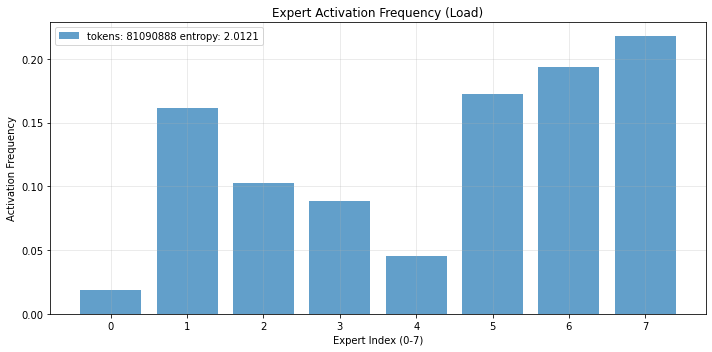

In [5]:
# Look at probe results
probe.print_count()
probe.plot_loadbalance()